# Анализ данных

In [87]:
import catboost
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [88]:
df_base = pd.read_csv('data/base.csv', index_col=0)

In [89]:
df_base

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.666340,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.202110,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.566180,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.202890,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.766320,-2.505783,65.315285,135.051590,-1074.464888,0.319401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4744755-base,-125.086300,4.735448,38.284935,-125.27671,209.788360,-47.870010,-628.127378,-71.077340,125.534355,29.341850,...,-70.364395,55.428260,-191.53702,122.978279,65.515260,108.963715,-52.795380,117.254510,-615.998268,-77.768555
4744759-base,-108.598390,5.454173,-22.191975,-158.71666,113.606110,-88.843430,-117.234538,137.317690,129.056690,164.754240,...,-70.360190,18.439003,-90.65145,-28.586794,68.691666,1.636499,-24.388298,93.530540,-1074.464888,-90.800400
4744762-base,-97.026730,-2.143885,-71.274090,-144.68066,149.464810,-21.572212,-759.626065,-108.151955,124.810135,118.760700,...,-55.961933,62.923470,-169.11832,108.452806,68.592970,43.205433,69.029830,129.536650,-1074.464888,4.718300


In [90]:
df_base.shape

(2918139, 72)

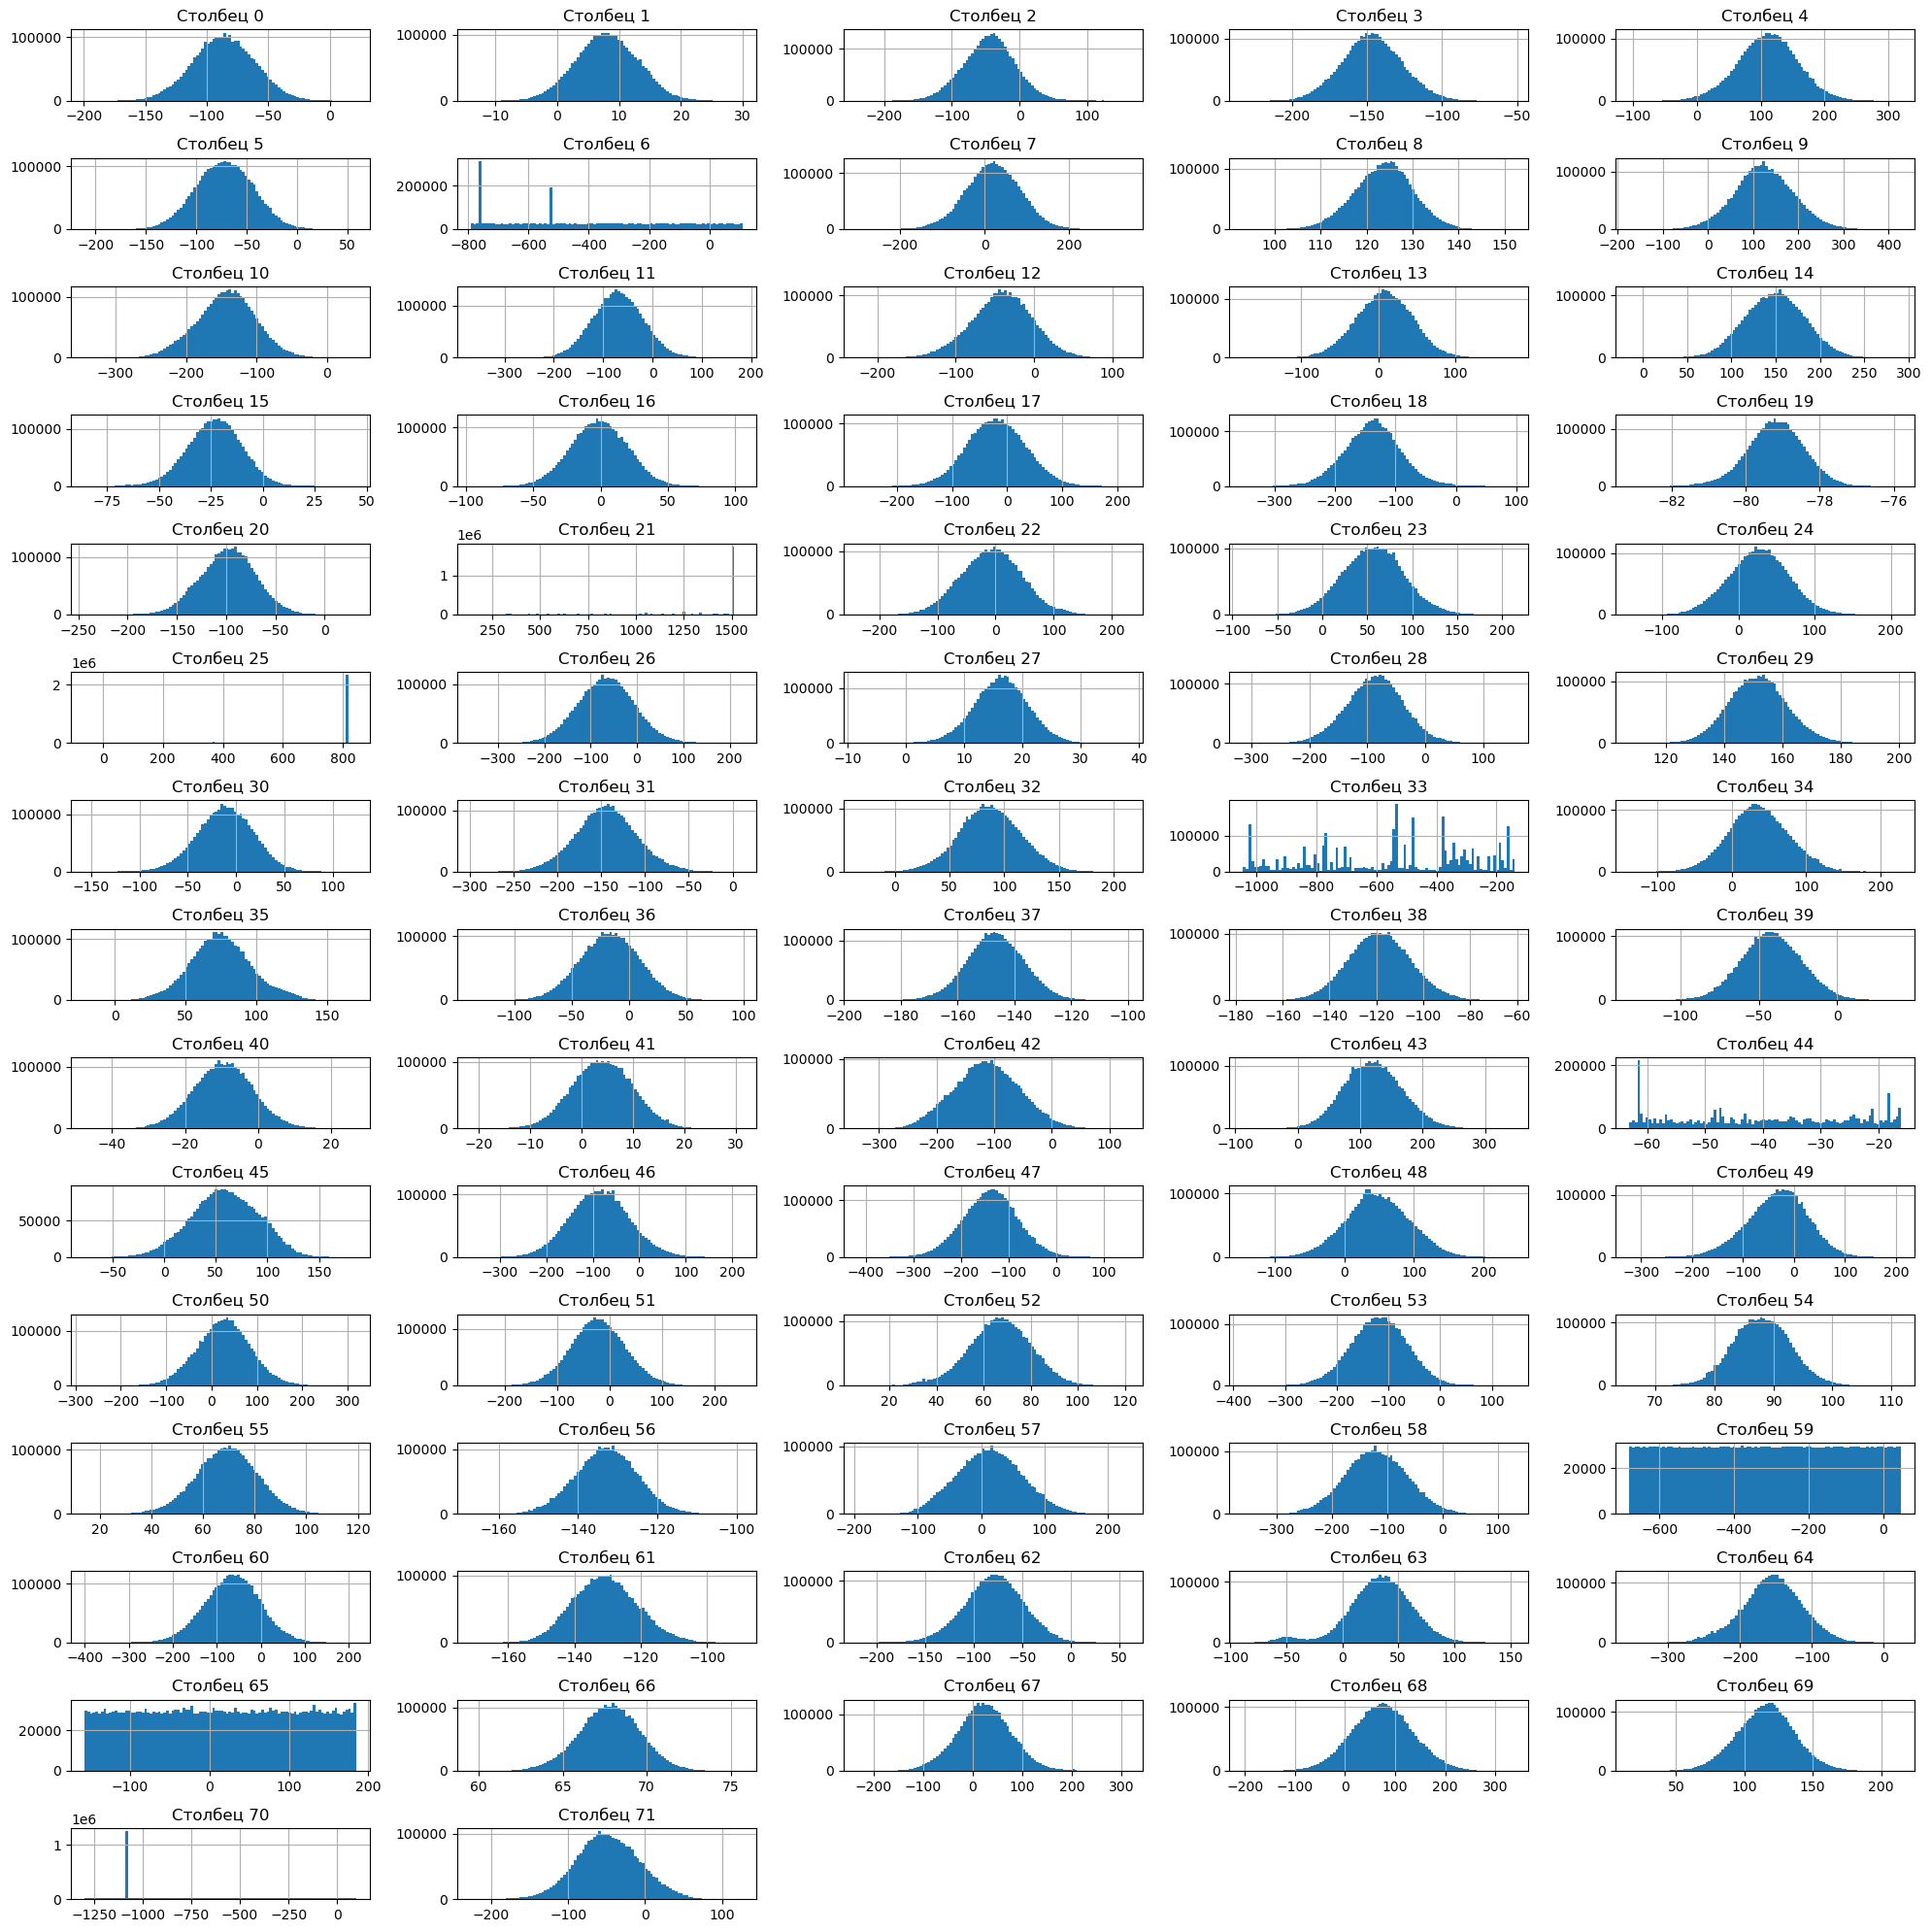

In [91]:
# Assuming df_base is your DataFrame
num_columns = df_base.shape[1]  # Get the number of columns
num_rows = 15  # Number of rows in the subplot grid (adjust as needed)
num_cols = 5   # Number of columns in the subplot grid (adjust as needed)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_columns:  # Check if the column index is within the number of columns in your DataFrame
        df_base.iloc[:, i].hist(bins=100, ax=ax)  # Plot the histogram for the i-th column
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')  # Turn off empty subplots if there are more subplots than columns

plt.tight_layout()
plt.show()

In [92]:
df_train = pd.read_csv("data/train.csv", index_col=0)

In [93]:
df_train.shape

(100000, 73)

In [94]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936680,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.802570,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.260390,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.697710,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.401980,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.146200,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.416750,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052540,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.092070,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995-query,-68.180530,11.657515,-63.179720,-188.726530,131.113100,-65.125340,-514.276885,95.990750,118.761185,-5.635696,...,38.573555,-133.087130,14.040794,66.477340,-36.148730,61.689774,107.037950,-1074.464888,-35.128250,811868-base
99996-query,-66.540890,2.201112,-70.292114,-146.167850,77.817140,-47.525654,-118.994688,-25.183374,131.499820,183.260880,...,33.324960,-110.576416,-84.448525,65.818100,-30.268772,133.784000,154.495860,-1144.590904,-108.663510,1460772-base
99997-query,-53.948240,4.726887,-29.278950,-147.182830,264.090670,-101.135630,-427.544045,68.057560,118.084310,192.449250,...,-14.146965,-184.663830,22.971385,67.347800,110.437100,35.785603,111.616710,-714.897734,-4.270569,2366140-base


In [95]:
df_train_visualisation = df_train.copy().drop(['Target'], axis=1)

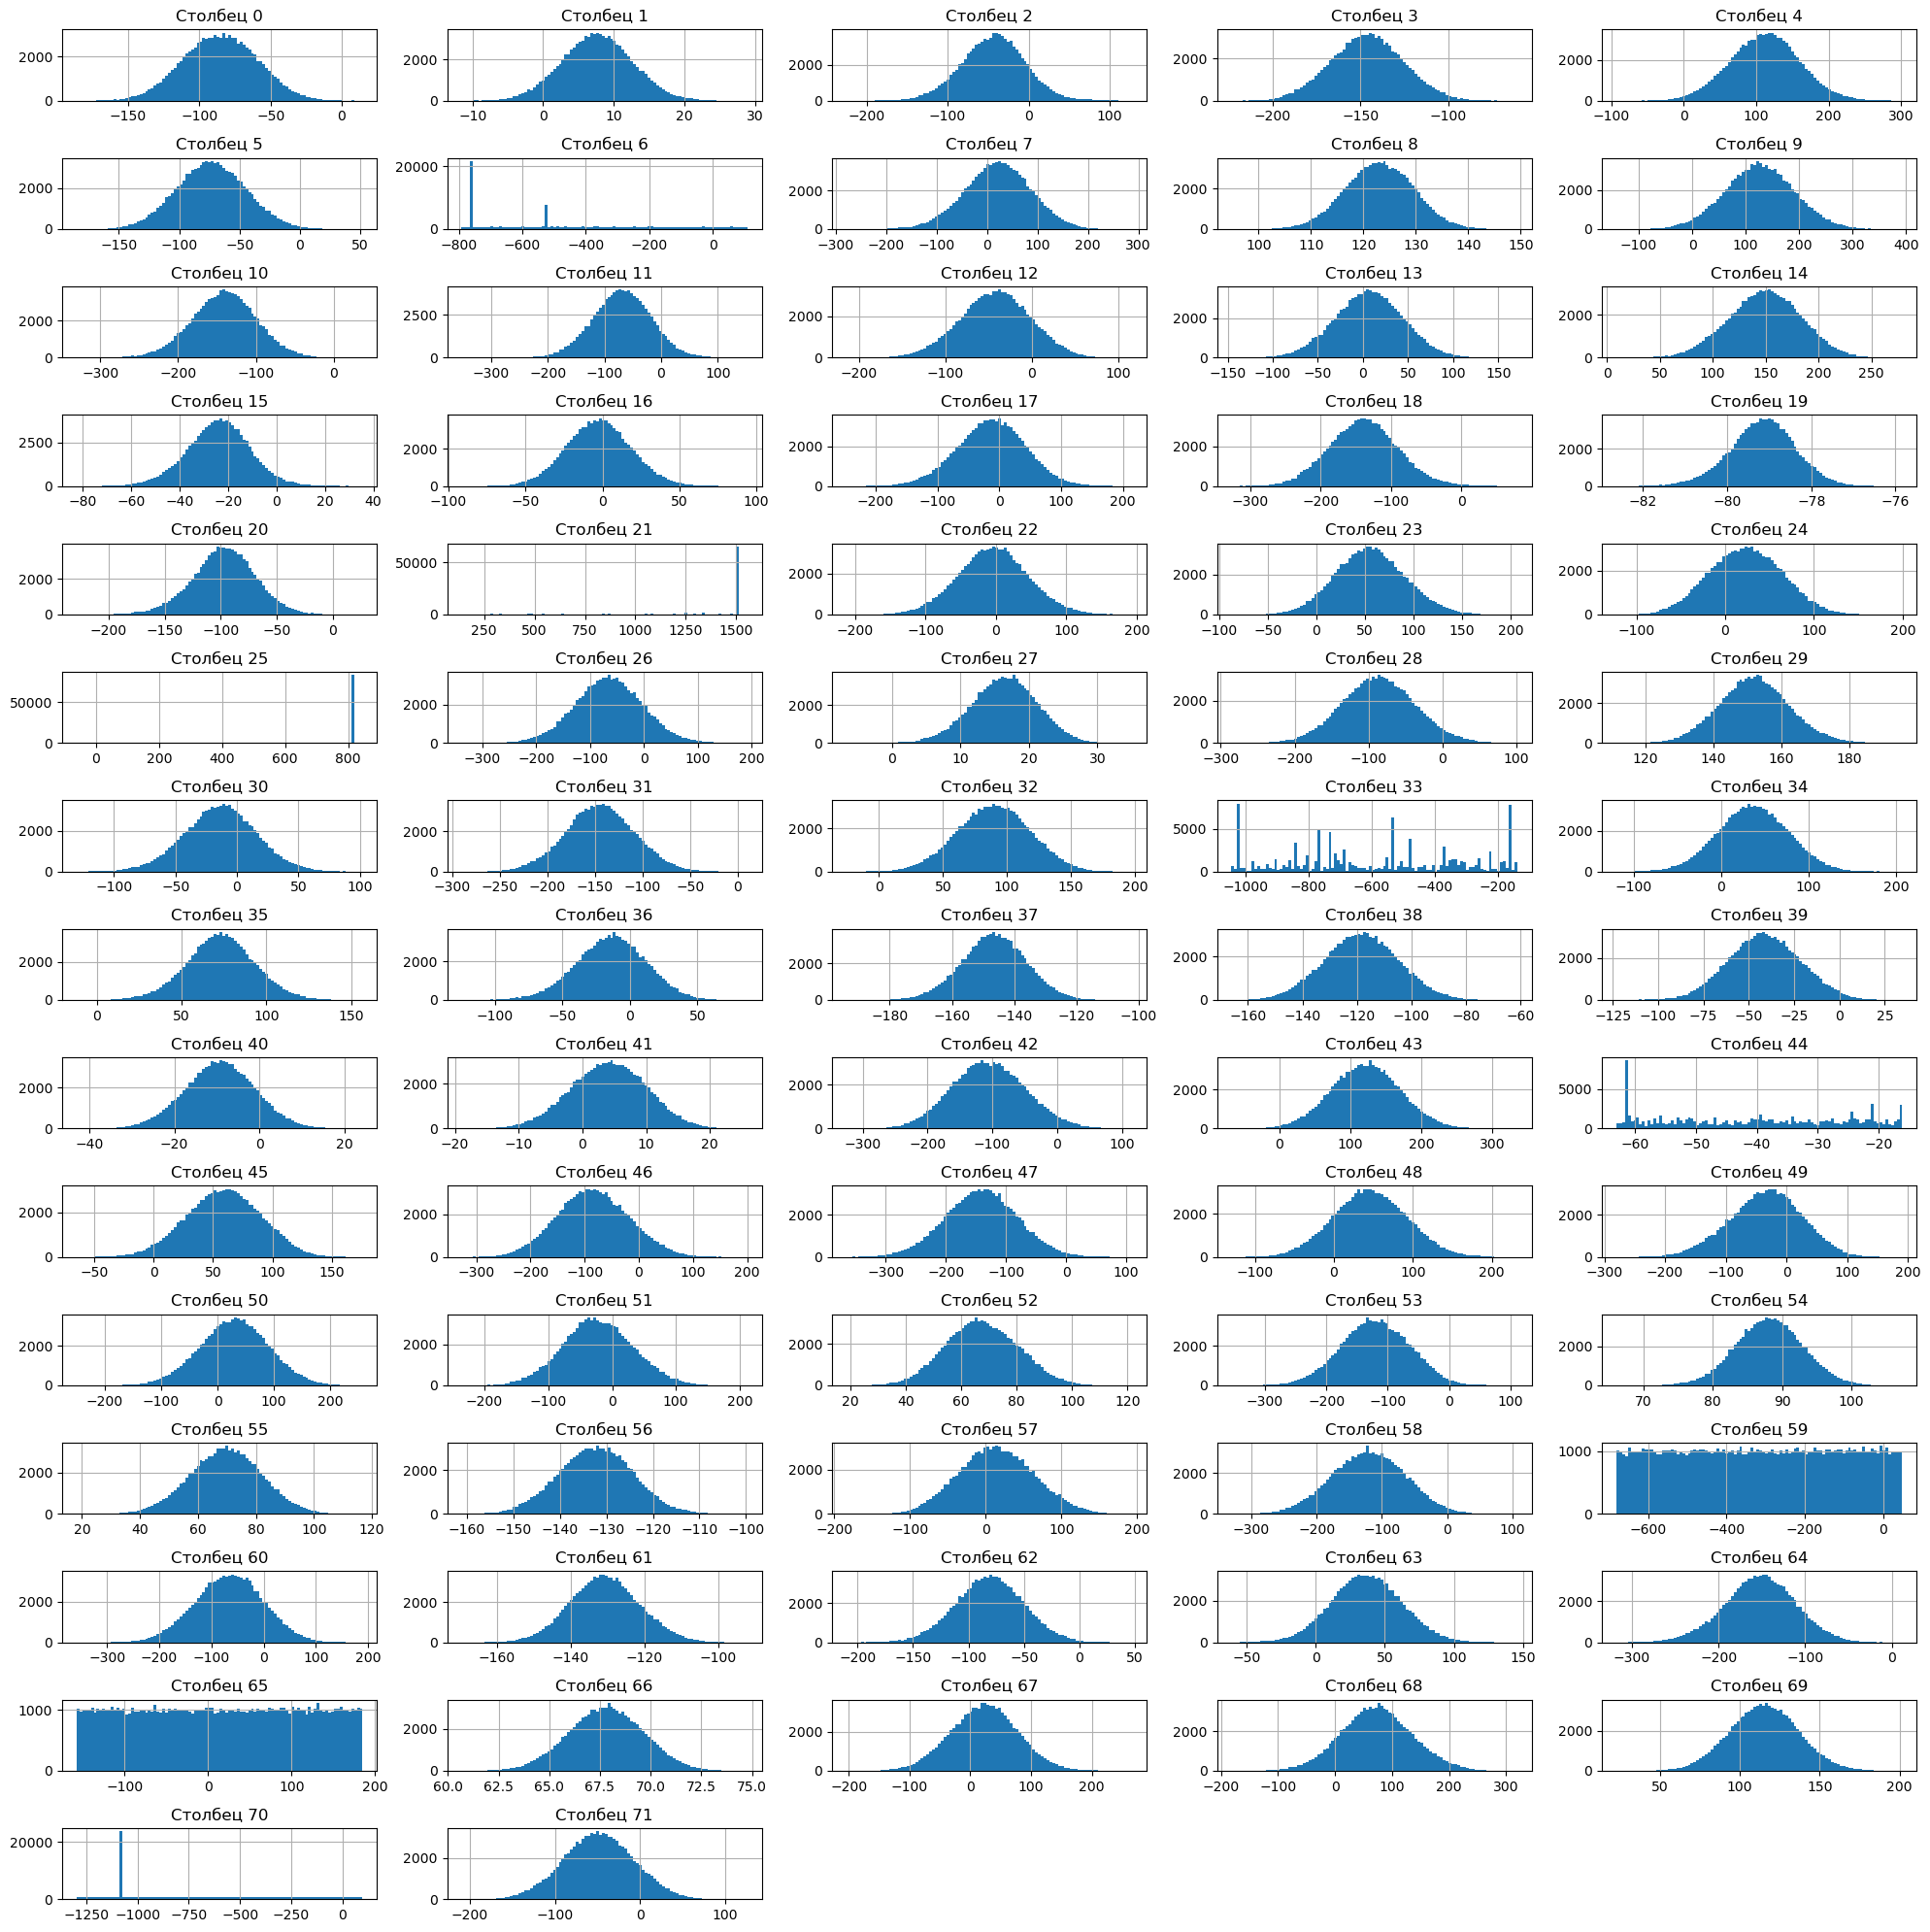

In [96]:
num_columns = df_train_visualisation.shape[1]  # Get the number of columns

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_columns:  # Check if the column index is within the number of columns in your DataFrame
        df_train_visualisation.iloc[:, i].hist(bins=100, ax=ax)  # Plot the histogram for the i-th column
        ax.set_title(f'Столбец {i}')
    else:
        ax.axis('off')  # Turn off empty subplots if there are more subplots than columns

plt.tight_layout()
plt.show()

In [97]:
X_test = pd.read_csv("data/validation.csv", index_col=0)
X_test.shape

(100000, 72)

In [98]:
y_test = pd.read_csv("data/validation_answer.csv", index_col=0)
y_test = y_test['Expected'].str.replace('-base', '').astype(float)
y_test.shape

(100000,)

# Обработка данных

In [99]:
for df in [df_base, df_train, X_test]:
    for column in ['6', '21', '25', '33', '44', '59', '65', '70']:
        df.drop(column, axis=1, inplace=True)

In [100]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [101]:
df_base = df_base / np.linalg.norm(df_base, axis=1)[:, np.newaxis]
df_train = df_train / np.linalg.norm(df_train, axis=1)[:, np.newaxis]

# Работа с Faiss

## IVFFlat

In [103]:
dims = df_base.shape[1] # количество признаков
n_cells = 1 # количество ячеек в индексе

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [104]:
idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))

idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [105]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [106]:
# idx_l2.nprobe = 100 # количество ячеек, которые будут просмотрены при поиске
r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

In [107]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx), "%")

69.729 %


# Выводы

1. Работа с сэмплом базовых данных без предобработки в колличестве 50 000 строк: **13.8%** точность на тестовой выборке
2. Кластеры 50, вся база: **8.681%, 14с.** 
3. Кластеры 50, вся база, n_porbe 10: **13.787%, 140с.**
4. Кластеры 50, вся база, n_porbe 10, нормализация: **14.374%, 154с.**
5. Вся база, нормализация: **14.396%, 655с.**
6. Кластеры 500, вся база, n_probe 100, нормализация: **14.391%, 93с.**
7. Кластеры 1700, вся база, n_probe 300, нормализация: **14.392%, 131с.**
8. Кластеры 500, вся база, n_probe 100, нормализация, удаление признайов без распределения: **17.044%, 148с.**
9. Кластеры 500, вся база, n_probe 100, нормализация, удаление признайов без распределения, удаление признаков с разбросанными показателями: **30.646%, 139с.**
10. Кластеры 500, вся база, n_probe 100, нормализация, удаление всех признаков без нормального распределения: **69.661%, 120с.**
11. Кластеры 500, вся база, n_probe 100, удаление всех признаков без нормального распределения: **69.601%, 120с.**
11. Кластеры 1, вся база, удаление всех признаков без нормального распределения: **69.729%, 570с.**